# Project Thus Far

## Overview

The overall purpose of this project is to use emotions to aid investing decisions. The project has two key components.

The first component predicts a stock price's movement for the next week. Sentiment analysis is performed on data scraped from [Twitter](https://twitter.com/) and [Reddit](https://www.reddit.com/) about a publicly traded stock of interest, in order to get an idea of how people feel about the stock. This analysis is combined with stock market data ([Yahoo! Finance](https://finance.yahoo.com/)) to generate a prediction of the stock price's short-term movement.

The second component is designed to aid an investor's rationality. Each investor makes an account in our system, which stores their basic personal information, tolerance for risk and current portfolio. Whenever the investor wishes to make a transaction, they must input their reasoning and current mood. Sentiment analysis is done on these inputs to determine whether the investor is in the right emotional headspace to make a sound decision. Furthermore, the investor is presented with graphics of their porfolio's projected movement with and without accounting for the transaction in question (where this projected movement is based on sentiment analysis of relevant Twitter and Reddit data). Lastly, the risk of their portfolio with the transaction is computed, and compared to their tolerance for risk (stored on their profile). All of these analyses are output to the investor to boost their rationality and emotional awareness before they make their final decision.

## Details

This notebook serves as a simple proof of concept. It begins with the creation of a user in our database, complete with their risk tolerance and current portfolio. Risk tolerance is an integer between 1 and 5 inclusive, where 1 means "losing this money impacts my living standard", and 5 means "I am happy to lose all of this money". We go through the process of purchasing a stock of interest.

For all stocks in the users portfolio and the stock of interest, we fetch 10 relevant Twitter Tweets. We compute a popularity score for each Tweet by using the number of likes and retweets the Tweet has. We then fetch the top 10 Reddit posts from three investing subreddits, and (at most) three subreddits relevant to each stock. The data is then aggregated into a DataFrame. We compute the sentiment of each post, and the overall sentiment that people have towards the company of interest.

Next, we scrape some statistics about the last month of the company's stock price from Yahoo! Finance, and plot the price movement over this time period. I use these statistics, and the overall sentiment people have towards the company of interest, to generate two distributions that are sampled from and combined to yield projected stock prices for the next week. The base distribution is a normal distribution, that has a mean of the last open stock price, and a standard deviation of the mean difference between the daily highs and lows of the stock over the previous month. The distribution is complemented by a uniform distribution which has at least one bound of 0. The other bound is the overall sentiment people have towards the company of interest scaled by a constant, divided by the average volume of traded stock for the past month. I then plot the last week's price movement, and a generated week of future price movement, by summing the values of the two above distributions.

# Database Initialization

## 1) Connect to Database

In [183]:
import pymysql


engine = pymysql.connect(host="<host>",
               user="<user>",
               password="<password>")

## 2) (Try to) Create Tables

In [2]:
# USERS
users_table = """CREATE TABLE IF NOT EXISTS USERS (
                     USER_ID INTEGER PRIMARY KEY AUTO_INCREMENT,
                     FIRST_NAME TEXT NOT NULL,
                     LAST_NAME TEXT NOT NULL,
                     EMAIL TEXT NOT NULL,
                     PASSWORD TEXT NOT NULL,
                     TOLERANCE_FOR_RISK INTEGER NOT NULL
                 );
              """
# STOCKS
portfolios_table = """CREATE TABLE IF NOT EXISTS PORTFOLIOS (
                          USER_ID INTEGER,
                          STOCK_NAME TEXT NOT NULL,
                          TICKER VARCHAR(10) NOT NULL,
                          VOLUME INTEGER NOT NULL,
                          PRIMARY KEY (USER_ID, TICKER),
                          FOREIGN KEY (USER_ID) REFERENCES USERS (USER_ID)
                      );
               """

engine.execute(users_table)
engine.execute(portfolios_table)

# User Initialization

## 1) Create Account

In [3]:
first_name = "First"
last_name = "Last"
email = "test@gmail.com"
password = "password123!"
tolerance_for_risk = 1

## 2) Validate Account Details and Uniqueness, Add User To Database, and Fetch `USER_ID`, `TOLERANCE_FOR_RISK`

In [4]:
import re


def validate_name(name):
    if re.fullmatch("[a-zA-Z-]{2,}", name):
        return True
    else:
        return False


def validate_email(email):
    if re.fullmatch("[a-zA-Z0-9.-_]+@[a-zA-Z0-9.-_]+\.[a-zA-Z]{2,}", email):
        return True
    else:
        return False
    
    
def validate_password(password):
    """
    Is at least 8 characters long, contains a special character, contains a number.
    """
    special_characters = "`~!@#$%^&*()-_=+[{}]\|;:'\",<.>/?"
    if (
        len(password) > 8
        and any(c in special_characters for c in password)
        and any(c.isnumeric() for c in password)
    ):
        return True
    else:
        return False


def validate_tolerance_for_risk(tolerance_for_risk):
    if 1 <= tolerance_for_risk <= 5 and isinstance(tolerance_for_risk, int):
        return True
    else:
        return False

In [5]:
check_unique = """SELECT
                      USER_ID
                  FROM
                      USERS
                  WHERE
                      EMAIL = %s
               """

unique = engine.execute(check_unique, (email,)).fetchall() == []

In [6]:
create_user = """INSERT INTO USERS(
                     FIRST_NAME,
                     LAST_NAME,
                     EMAIL,
                     PASSWORD,
                     TOLERANCE_FOR_RISK
                 )
                 VALUES(%s, %s, %s, %s, %s)
              """


if (
    validate_name(first_name)
    and validate_name(last_name)
    and validate_password(password)
    and validate_tolerance_for_risk(tolerance_for_risk)
    and unique
   ):
    engine.execute(create_user, (first_name,
                                 last_name,
                                 email,
                                 password,
                                 tolerance_for_risk)
                  )
else:
    print("Invalid details")

Invalid details


In [8]:
get_user_id_and_tolerance_for_risk = """SELECT
                                            USER_ID,
                                            TOLERANCE_FOR_RISK
                                        FROM
                                            USERS
                                        WHERE
                                            EMAIL = %s
                                     """

user_id, tolerance_for_risk = engine.execute(get_user_id_and_tolerance_for_risk, (email,)).fetchall()[0]

## 3) Add Stocks to Current Portfolio

In [9]:
stock_ticker_quantity = [("Microsoft", "MSFT", 5),
                         ("Tesla", "TSLA", 2),
                         ("Ford", "F", 10),
                         ("General Motors", "GM", 10)
                        ]

### 3)a) Check That The Stocks Are Valid

In [10]:
import yfinance as yf


def check_ticker_is_valid(ticker):
    """
    Takes in ticker symbol, and outputs True/False whether it exists on Yahoo! Finance.
    """
    
    info = yf.Ticker(ticker).info
    if ("regularMarketPrice" in info and info["regularMarketPrice"] is None 
        and "preMarketPrice" in info and info["preMarketPrice"] is None
        and "logo_url" in info and info["logo_url"] is None
       ):
        return False
    else:
        return True
    

def check_quantity_is_valid(volume):
    """
    Takes in the stock volume, and returns whether it is greater than 0.
    """
    return volume > 0

In [ ]:
add_stock_to_portfolio = """INSERT INTO PORTFOLIOS(
                                USER_ID,
                                STOCK_NAME,
                                TICKER,
                                VOLUME
                            )
                            VALUES(%s, %s, %s, %s)
                         """

for stock_name, ticker, quantity in stock_ticker_quantity:
    if check_ticker_is_valid(ticker) and check_quantity_is_valid(quantity):
        engine.execute(add_stock_to_portfolio, (user_id, stock_name, ticker, quantity))
    else:
        print(f"Stock {stock} with Ticker {ticker} could not be found, so was ignored.")

### 3)b) Define Functions for Pulling Reddit and Twitter Data and Predicting Future Score

In [108]:
import requests
import pandas as pd
import praw


def pull_reddit_posts(stock_name):
    """
    Return a DataFrame of recent Reddit posts relevant to the inputted stock.
    """

    reddit = praw.Reddit(
        client_id="<client_id>",
        client_secret="<client_secret>",
        user_agent="<user_agent>",
    )

    subreddits = [reddit.subreddit("Trading"),
                  reddit.subreddit("investing"),
                  reddit.subreddit("stocks")]
    subreddits_for_coi = reddit.subreddits.search_by_name(stock_name)
    if subreddits_for_coi:
        subreddits.extend(subreddits_for_coi[:min(len(subreddits_for_coi), 3)])

    posts = []
    
    for subreddit in subreddits:
        for submission in subreddit.hot(limit=10):
            text = submission.title + "\n" + submission.selftext
            if stock_name in text:
                posts.append((submission.id, text, submission.score)) 

    return pd.DataFrame(columns=["id", "text", "score"], data=posts)

    
def score_tweet(retweet_count, quote_count, like_count):
    """
    Return an integer score of a tweet as a function of retweet_count, quote_count, and like_count.
    """
    return int(retweet_count + quote_count + like_count)
    
    
def pull_twitter_posts(stock_name):
    """
    Return a DataFrame of recent Twitter Tweets relevant to the inputted stock.
    """

    twitter_search_endpoint = "https://api.twitter.com/2/tweets/search/recent"
    headers = {
        "Authorization" : "Bearer <bearer_token>"
    }
    parameters  = {
        "query" : stock_name,
        "tweet.fields" : "text,author_id,created_at,public_metrics",
    }

    res = requests.get(twitter_search_endpoint, headers=headers, params=parameters) 
    tweets = res.json()
    posts = []

    if "data" in tweets:
        for d in tweets["data"]:
            score = score_tweet(d["public_metrics"]["retweet_count"],
                                d["public_metrics"]["quote_count"],
                                d["public_metrics"]["like_count"]
                               )
            posts.append((d["id"], d["text"], score))
        
    return pd.DataFrame(columns=["id", "text", "score"], data=posts)

In [13]:
import pickle
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import numpy as np


# fetch our pre-trained models and ID to word mappings from memory
reddit_model = pickle.load(open("../models/reddit_logistic_regression.sav", "rb"))
reddit_id_to_word = pickle.load(open("../models/reddit_id_to_word.sav", "rb"))
twitter_model = pickle.load(open("../models/twitter_logistic_regression.sav", "rb"))
twitter_id_to_word = pickle.load(open("../models/twitter_id_to_word.sav", "rb"))


def process_text(text):
    """
    Returns list of stems of non-stopwords.
    """
    
    word_list = word_tokenize(str(text))
    
    filtered_words = [word for word in word_list if word not in stopwords.words("english")]
    
    ps = PorterStemmer()
    return [ps.stem(word) for word in filtered_words]



def vectorize_processed_text(processed_text, id_to_word):
    """
    Returns vectors of processed text, using id_to_word.
    """
    
    dict_id_to_count = {i: 0 for i in range(len(id_to_word))}
    
    hits = id_to_word.doc2bow(processed_text)
    for hit in hits:
        dict_id_to_count[hit[0]] = hit[1]
    
    return np.array([v for v in dict_id_to_count.values()])


def predict_reddit_score(reddit_text):
    """
    Returns an integer which is the predicted future score of the post after the
    majority of people who will see and react to the post have done so.
    """
    
    processed_text = process_text(reddit_text)
    vectorized_processed_text = vectorize_processed_text(processed_text, reddit_id_to_word)
    return reddit_model.predict(vectorized_processed_text.reshape(1, -1))[0]  # have to reshape since single entry
    

def predict_twitter_score(twitter_text):
    """
    Returns an integer which is the predicted future score of the post after the
    majority of people who will see and react to the post have done so.
    """
    
    processed_text = process_text(twitter_text)
    vectorized_processed_text = vectorize_processed_text(processed_text, twitter_id_to_word)
    return twitter_model.predict(vectorized_processed_text.reshape(1, -1))[0]  # have to reshape since single entry

### 3)c) Define Function for Pulling Stock Data

In [14]:
import yfinance as yf
import datetime


def pull_stock_price_history(ticker):
    """
    Returns DataFrame containing the last 30 days worth of price history for the input stock ticker.
    """
    
    today = datetime.date.today()
    start = (today - datetime.timedelta(days=30)).strftime("%Y-%m-%d")
    end = today.strftime("%Y-%m-%d")

    return yf.download(ticker, start, end)

### 3)d) Define a Cache, Storing API-Intensive Information That Will Be Reused

In [15]:
from textblob import TextBlob


# {ticker: (sentiment score from Reddit posts and Tweets, last month's price data)}
# {string: (int, DataFrame)}
cache = dict()
    

def add_to_cache(stock_name, ticker, cache):
    """
    Add API-intensive information to cache for the input ticker and stock_name.
    Note: only use after validating the Ticker with check_ticker_is_valid()
    """
    
    # pull Reddit posts and Tweets
    df_reddit_posts = pull_reddit_posts(stock_name)
    df_twitter_posts = pull_twitter_posts(stock_name)
    
    # predict future scores
    df_reddit_posts["predicted_score"] = df_reddit_posts["text"].apply(lambda x: predict_reddit_score(x))
    df_twitter_posts["predicted_score"] = df_twitter_posts["text"].apply(lambda x: predict_twitter_score(x))
    
    # store in combined DataFrame
    df_reddit_and_twitter_posts = pd.concat([df_reddit_posts, df_twitter_posts])
    
    # calculate sentiment scores
    df_reddit_and_twitter_posts["sentiment_score"] = df_reddit_and_twitter_posts["text"].apply(lambda x: TextBlob(x).sentiment.polarity)
    
    # calculate total predicted unexpressed sentiment
    total_predicted_unexpressed_sentiment = 0
    for _, r in df_reddit_and_twitter_posts.iterrows():
        total_predicted_unexpressed_sentiment += max(0, r["predicted_score"]-r["score"]) * r["sentiment_score"]
    
    # pull last month's price data
    df_stock_price_history = pull_stock_price_history(ticker)
    
    # finally, add data to cache!
    cache[ticker] = (total_predicted_unexpressed_sentiment, df_stock_price_history)

### 3)e) Define Functions for Validating a Portfolio

In [118]:
def calculate_risks_of_stocks_in_portfolio(portfolio, cache):
    """
    Returns a list of the risk of each stock in the input portfolio.
    The risk of a stock is defined as the standard deviation of underlying stock price model
    as a percentage of the average price for that stock over the last 30 days
    """
    
    risks = []
    
    for entry in portfolio:
        entry_price_history = cache[entry[1]][1]  # cache[ticker][price history]
        
        high_low_diffs = [high - low for high, low in zip(entry_price_history["High"], entry_price_history["Low"])]
        average_difference_highs_and_lows = sum(high_low_diffs) / len(high_low_diffs)
        average_stock_price = entry_price_history["Open"].mean()
        risks.append(average_difference_highs_and_lows*100 / average_stock_price)
        
    return risks


def calculate_portfolio_weights(portfolio, cache):
    """
    Returns a list of the normalized weights of each stock in the input portfolio.
    Raw weight is defined as the last opening price * quantity owned for a stock.
    """
    
    portfolio_weights = []
    
    for entry in portfolio:
        entry_price_history = cache[entry[1]][1]  # cache[ticker][price history]
            
        portfolio_weights.append(entry_price_history.iloc[-1]["Open"] * entry[2])
                
    # normalize portfolio weights
    sum_portfolio_weights = sum(portfolio_weights)
    if sum_portfolio_weights != 0:
        portfolio_weights = [x / sum_portfolio_weights for x in portfolio_weights]
        
    return portfolio_weights


def calculate_portfolio_risk(portfolio, cache):
    """
    Return the portfolio's risk, which is defined to be the weighted average of the average
    difference in High, Low for the last month, as a percentage of average stock price for the last month.
    Note that portfolio can be any list of tuples of the form (stock_name, ticker, volume)
    """
    
    # for stock in portfolio whose ticker symbol is not in cache, call add_to_cache()
    for entry in portfolio:
        if entry[1] not in cache:
            add_to_cache(entry[0], entry[1], cache)

    # risks = [average difference in High and Low for stock 0 * 100 / average price of stock 0, ...]
    # = [standard deviation of underlying stock price model as a percentage of the average price for stock 0, ...]
    #
    # portfolio_weights = [last opening price * quantity owned for stock 0, ...]
    risks = calculate_risks_of_stocks_in_portfolio(portfolio, cache)
    portfolio_weights = calculate_portfolio_weights(portfolio, cache)
    
    # compute sum of risk of each stock * weight
    # = portfolio risk
    return sum([risk * weight for risk, weight in zip(risks, portfolio_weights)])

In [119]:
def validate_portfolio_risk(portfolio_risk, tolerance_for_risk):
    """
    Return True if the input portfolio's risk is less than the input tolerance for risk, and False otherwise.
    Checks whether portfolio_risk <= 3*tolerance_for_risk
    Which is to say:
        - for a tolerance_for_risk of 1, weighted average standard deviation is less than 3*1% = 3% of portfolio's value 
        - for a tolerance_for_risk of 5, weighted average standard deviation is less than 3*5% = 15% of portfolio's value
    """
    
    return portfolio_risk <= 3*tolerance_for_risk

### 3)f) Define Function for Fetching a User's Portfolio

In [19]:
def fetch_portfolio_for_user(user_id):
    """
    Fetch stock tickers and quantities in user_id's portfolio from the database.
    """
    fetch_portfolio_for_user = """SELECT
                                      STOCK_NAME,
                                      TICKER,
                                      VOLUME
                                  FROM
                                      PORTFOLIOS
                                  WHERE
                                      USER_ID = %s
                               """
    return engine.execute(fetch_portfolio_for_user, (user_id,)).fetchall()

### 3)g) Finally, Fetch and Validate the Initial Portfolio's Risk

In [120]:
user_portfolio = fetch_portfolio_for_user(user_id)
portfolio_risk = calculate_portfolio_risk(user_portfolio, cache)

if validate_portfolio_risk(portfolio_risk, tolerance_for_risk):
    print("Your initial portfolio is within your risk tolerance.")
else:
    print("Your initial portfolio too risky.")

Your initial portfolio too risky.


## 4) Enter Stock, Ticker and Quantity to Buy/Sell

In [109]:
stock_name = "Bank of America"
ticker = "BAC"
action = "buy"
quantity = 5

## 5) Confirm the Validity of the Transaction

In [110]:
def check_transaction_is_valid(ticker, action, quantity):
    """
    Return True if the action is valid, and False otherwise.
    Validity is defined by the action, existence of the ticker, the positivity of the quantity,
    and the quantity being less than the owned volume for sell.
    """
    
    if action == "buy":
        if check_ticker_is_valid(ticker) and check_quantity_is_valid(quantity):
            return True
        else:
            return False
    if action == "sell":
        fetch_volume_of_stock = """SELECT
                                       VOLUME
                                   FROM
                                       PORTFOLIOS
                                   WHERE
                                       USER_ID = %s
                                       AND TICKER = %s
                                """
        volume_owned = engine.execute(fetch_volume_of_stock, (user_id, ticker)).fetchall()
        if (check_ticker_is_valid(ticker)
            and check_quantity_is_valid(quantity)
            and volume_owned and quantity <= volume_owned[0][0]
           ):
                return True
        else:
            return False
    else:
        return False

In [111]:
if check_transaction_is_valid(ticker, action, quantity):
    print("Valid transaction.")
else:
    print(f"Invalid transaction. Ensure you have entered a valid ticker ({ticker}) and quantity ({quantity}) (with respect to volume owned for sell)")

Valid transaction.


## 5) Ask Questions
- Reasoning for transaction
- Current mood

In [115]:
reasoning = input("What is your reasoning for this transaction? ")
current_mood = input("What is your current mood? ")

What is your reasoning for this transaction? I want to reduce my risk by investing in a stable bank.
What is your current mood? Calm


## 6) Validate Rationality of Answers to Questions

In [116]:
from textblob import TextBlob


def validate_answers_to_questions(answers):
    
    for answer in answers:
        if abs(TextBlob(answer).sentiment.polarity) > 0.4:
            return False
    
    return True

In [117]:
validate_answers_to_questions([reasoning, current_mood])

True

## 7) Generate Data About Portfolio Before and After Transaction

### 7)a) Generate Future Portfolio from Current Portfolio

In [112]:
def generate_future_portfolio(current_portfolio, transacted_stock_name, transacted_ticker, action, transacted_quantity, cache):
    """
    Return the current portfolio after taking into account the already verified transaction.
    If buying a new stock, adds it to cache.
    """
    
    future_portfolio = []

    if action == "buy":
        
        change_made = False
        
        for stock_name, ticker, quantity in current_portfolio:
            if ticker == transacted_ticker:
                future_portfolio.append((stock_name, ticker, quantity+transacted_quantity))
                change_made = True
            else:
                future_portfolio.append((stock_name, ticker, quantity))
                
        if not change_made:
            # new stock which is not in portfolio
            future_portfolio.append((transacted_stock_name, transacted_ticker, transacted_quantity))
            add_to_cache(transacted_stock_name, transacted_ticker, cache)
            
        return future_portfolio
    else:
        # sell
        for stock_name, ticker, quantity in current_portfolio:
            if ticker == transacted_ticker:
                if quantity-transacted_quantity > 0:
                    future_portfolio.append((stock_name, ticker, quantity-transacted_quantity))
            else:
                future_portfolio.append((stock_name, ticker, quantity))
        
        return future_portfolio

In [113]:
current_portfolio = fetch_portfolio_for_user(user_id)
future_portfolio = generate_future_portfolio(current_portfolio, stock_name, ticker, action, quantity, cache)

[*********************100%***********************]  1 of 1 completed


### 7)b) Calculate Current and Future Portfolio Risks

In [80]:
current_portfolio_risk = calculate_portfolio_risk(current_portfolio, cache)
future_portfolio_risk = calculate_portfolio_risk(future_portfolio, cache)

### 7)c) Define Function for Generating a Prediction of an Input Stock in Cache over the next Week

In [93]:
import numpy as np


def predict_stock_next_week(ticker, cache):
    """
    Return a DataFrame containing the price movement of the input stock over the past and future week (predicted).
    """
        
    aggregate_sentiment, df_stock_prices = cache[ticker]
    df_future_stock_prices = df_stock_prices.copy()
    
    mean_volume = df_stock_prices["Volume"].mean()
    sentiment_scaled_by_volume = aggregate_sentiment * 100_000 / mean_volume if mean_volume != 0 else 0
    
    # main distribution: normal random variable with
    #     - a mean of the previous Open
    #     - a standard deviation of the average difference between High and Low for each day
    high_low_diffs = [high - low for high, low in zip(df_stock_prices["High"], df_stock_prices["Low"])]
    normal_std = sum(high_low_diffs) / len(high_low_diffs)

    # sentiment noise: uniform random variable of sentiment scaled by volume
    uniform_low, uniform_high = (0, sentiment_scaled_by_volume) if sentiment_scaled_by_volume > 0 else (sentiment_scaled_by_volume, 0)

    df_future_stock_prices.drop(columns=["High", "Low", "Close", "Adj Close", "Volume"], inplace=True)

    for i in range(7):
        previous = df_future_stock_prices.iloc[-1]
        date = pd.to_datetime(previous.name + datetime.timedelta(days=1), format="%Y-%m-%d")
        new_row = pd.DataFrame(
            [[max(0, np.random.normal(previous["Open"], normal_std) + np.random.uniform(low=uniform_low, high=uniform_high))]],
            columns=["Open"],
            index=[date]
        )
        df_future_stock_prices = pd.concat([df_future_stock_prices, pd.DataFrame(new_row)], ignore_index=False)

    return df_future_stock_prices.iloc[-14:]

### 7)d) Define Function for Predicting the Movement of an Input Portfolio over the next Week

In [174]:
def predict_portfolio_next_week(portfolio, cache):
    """
    Return a Series containing the price movement of the input portfolio over the past and future week (predicted).
    Return None if the input portfolio is empty.
    """
    
    if len(portfolio) == 0:
        return None
    
    # get price predictions for each stock
    stock_price_predictions = []
    for stock_name, ticker, quantity in portfolio:
        stock_price_predictions.append(predict_stock_next_week(ticker, cache))
        
    # combine DataFrames
    if len(stock_price_predictions) == 1:
        return stock_price_predictions[0]["Open"]
    else:
        df_combined = stock_price_predictions[0].join(stock_price_predictions[1], rsuffix="1")

        for i in range(2, len(stock_price_predictions[2:])+2):
            df_combined = df_combined.join(stock_price_predictions[i], rsuffix=str(i))
            
        return df_combined.sum(axis=1)

### 7)e) Calculate and Plot Current and Future Portfolio Projected Price Movements

Text(0.5, 1.0, 'Current Portfolio: Last Week and Projected Next Week Price Movement')

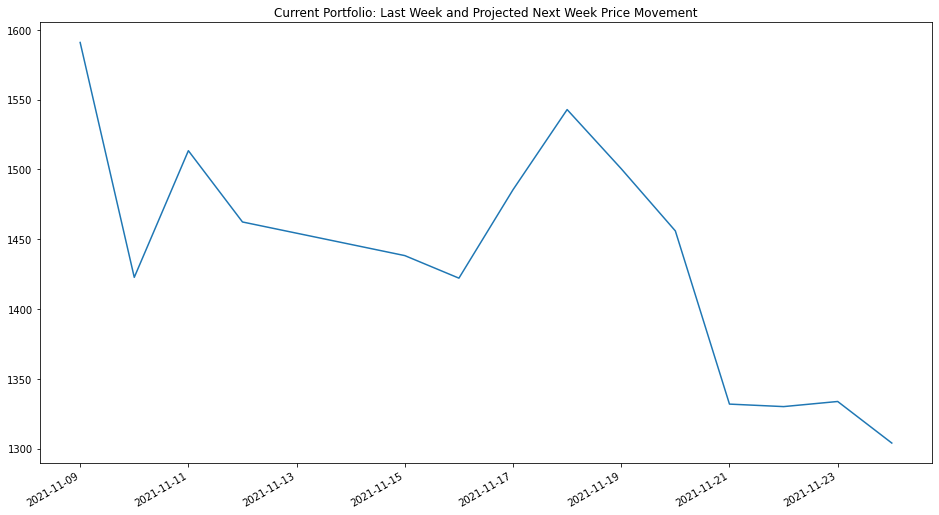

In [176]:
import matplotlib.pyplot as plt


predict_portfolio_next_week(current_portfolio, cache).plot(label="current_portfolio_prediction", figsize = (16, 9))
plt.title(f"Current Portfolio: Last Week and Projected Next Week Price Movement")

Text(0.5, 1.0, 'Future Portfolio: Last Week and Projected Next Week Price Movement')

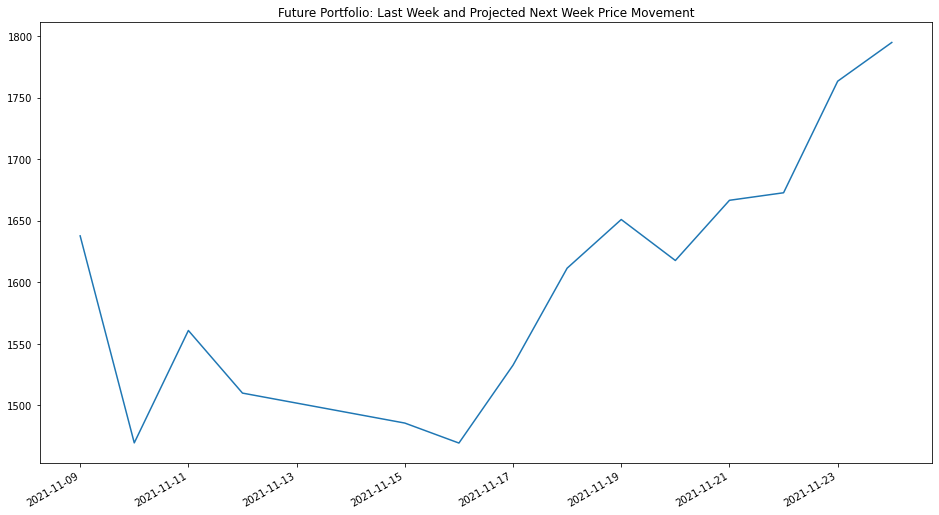

In [178]:
predict_portfolio_next_week(future_portfolio, cache).plot(label="future_portfolio_prediction", figsize = (16, 9))
plt.title(f"Future Portfolio: Last Week and Projected Next Week Price Movement")

## Update Portfolio (if the user wishes to proceed)

In [186]:
delete_old_portfolio = """DELETE FROM PORTFOLIOS
                          WHERE USER_ID = %s
                       """

engine.execute(delete_old_portfolio, (user_id,))

In [188]:
for stock_name, ticker, volume in future_portfolio:
    engine.execute(add_stock_to_portfolio, (user_id, stock_name, ticker, volume))